In [1]:
crime_classes = ['Abuse', 'Arrest', 'Arson', 'Assault', 'RoadAccidents', 'Burglary', 'Explosion', 'Fighting', 'Robbery', 'Shooting', 'Stealing', 'Shoplifting', 'Vandalism', 'Normal_Videos']

In [2]:
def preprocess_text_annotations(annotation_file):
    video_annotations = {}
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split(' ')
        video_id = parts[0]
        start_time = parts[1]
        end_time = parts[2]
        description = ' '.join(parts[3:]).replace('##', '')  
        if video_id not in video_annotations:
            video_annotations[video_id] = ''
        video_annotations[video_id] += " " + description
    return video_annotations

In [3]:
train_ants = preprocess_text_annotations('/kaggle/input/annotations-formatted/Formatted_annotations/formatted_UCFCrime_Train.txt')
test_ants =  preprocess_text_annotations('/kaggle/input/annotations-formatted/Formatted_annotations/formatted_UCFCrime_Test.txt')
val_ants =  preprocess_text_annotations('/kaggle/input/annotations-formatted/Formatted_annotations/formatted_UCFCrime_Val.txt')

In [4]:
i3d_features_train = {}
i3d_features_val = {}
i3d_features_test = {}


In [5]:
import gc 
gc.collect()

11

In [6]:
import os
import numpy as np

base_dir = "/kaggle/input/ucf-crime01/UCF-Crime/all_rgbs"
i3d_features_dict = {}

for class_name in crime_classes:
    class_dir = os.path.join(base_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.npy'):
            video_id = file_name.split('.')[0]
            i3d_features_file = os.path.join(class_dir, file_name)
            i3d_features = np.load(i3d_features_file)
            i3d_features_dict[video_id] = i3d_features


i3d_features_train = {}
i3d_features_val = {}
i3d_features_test = {}


for video_id, features in i3d_features_dict.items():
    if video_id in train_ants:
        i3d_features_train[video_id] = features
    elif video_id in val_ants:
        i3d_features_val[video_id] = features
    elif video_id in test_ants:
        i3d_features_test[video_id] = features


print(f'Number of training samples: {len(i3d_features_train)}')
print(f'Number of validation samples: {len(i3d_features_val)}')
print(f'Number of test samples: {len(i3d_features_test)}')


Number of training samples: 1165
Number of validation samples: 379
Number of test samples: 310


In [7]:
import gc
gc.collect()

583

In [8]:
import pandas as pd 

def populate_data(annotation_dict,  i3d_dict):
    data_list = []
    for video_id, annotations_text in annotation_dict.items():
        video_class = next((c for c in crime_classes if video_id.startswith(c)), None)
        data_list.append({
                'video_id': video_id,
                'i3d_features': i3d_dict[video_id],
                'annotations': annotations_text,
                'video_class': video_class
            })
    return data_list



train_data = populate_data(train_ants, i3d_features_train)
val_data = populate_data(val_ants, i3d_features_val)
test_data = populate_data(test_ants, i3d_features_test)


train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [9]:
train_df['video_class'].unique()

array(['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
       'Fighting', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting',
       'Stealing', 'Vandalism', 'Normal_Videos'], dtype=object)

In [10]:
import gc
gc.collect()

0

In [11]:
train_classes_raw = train_df["video_class"]
train_ants= train_df["annotations"]

val_classes_raw = val_df["video_class"]
val_ants = val_df["annotations"]

test_classes_raw = test_df["video_class"]
test_ants = test_df["annotations"]

In [12]:

from sklearn import preprocessing
import tensorflow as tf

label_encoder = preprocessing.LabelEncoder()

label_encoder.fit(crime_classes)
train_classes = label_encoder.transform(train_classes_raw)
train_classes = tf.keras.utils.to_categorical(train_classes, 14)

val_classes = label_encoder.transform(val_classes_raw)
val_classes = tf.keras.utils.to_categorical(val_classes, 14)

test_classes = label_encoder.transform(test_classes_raw)
test_classes = tf.keras.utils.to_categorical(test_classes, 14)

print("Train, Validation, and Test classes have been encoded.")

2024-08-10 04:13:33.008525: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 04:13:33.008697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 04:13:33.190425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train, Validation, and Test classes have been encoded.


In [13]:
class_labels = label_encoder.classes_

In [14]:
import gc
gc.collect()

23

In [15]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def clean_whitespace(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def remove_special_characters(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)

def stem_text(text):
    stemmer = PorterStemmer()
    return ' '.join(stemmer.stem(word) for word in text.split())

In [16]:
train_ants = train_ants.apply(lambda x: clean_whitespace(remove_special_characters(remove_punctuation(x.lower()))))
test_ants = test_ants.apply(lambda x: clean_whitespace(remove_special_characters(remove_punctuation(x.lower()))))
val_ants = val_ants.apply(lambda x: clean_whitespace(remove_special_characters(remove_punctuation(x.lower()))))


train_ants = train_ants.apply(remove_stop_words).apply(stem_text)
test_ants = test_ants.apply(remove_stop_words).apply(stem_text)
val_ants = val_ants.apply(remove_stop_words).apply(stem_text)

In [17]:
max_sequence_length = max(train_ants.apply(lambda x: len(x.split())).max(), test_ants.apply(lambda x: len(x.split())).max(), val_ants.apply(lambda x: len(x.split())).max())

In [18]:
max_sequence_length

11362

In [19]:
all_messages = pd.concat([train_ants, test_ants, val_ants])

In [20]:
len(all_messages)

1854

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 12000
MAX_SEQUENCE_LENGTH = 11362  
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(all_messages)


train_sequences = tokenizer.texts_to_sequences(train_ants)
val_sequences = tokenizer.texts_to_sequences(val_ants)
test_sequences = tokenizer.texts_to_sequences(test_ants)


train_data_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_data_padded = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [22]:
import numpy as np

glove_dict = {} 
with open('/kaggle/input/glove01/glove.6B.50d.txt', "r", encoding="utf8") as glove_file:     
    for line in glove_file:
        
        emb_line = line.split()      
        emb_token = emb_line[0]         
        emb_vector = np.array(emb_line[1:], dtype=np.float32)
        
        if emb_vector.shape[0] == 50:    
            glove_dict[emb_token] = emb_vector 

print("Dictionary Size: ", len(glove_dict))

Dictionary Size:  400000


In [23]:
vocab_len = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_len, 50))

for word, id in tokenizer.word_index.items():  
    try:
        embedding_vector = glove_dict.get(word) 
        if embedding_vector is not None:         
            embedding_matrix[id] = embedding_vector
    except:
        pass

print("Size of Embedding matrix :", embedding_matrix.shape)

Size of Embedding matrix : (2512, 50)


In [24]:
train_i3d_features = np.array(train_df['i3d_features'].tolist()) 
val_i3d_features = np.array(val_df['i3d_features'].tolist())
test_i3d_features = np.array(test_df['i3d_features'].tolist())

In [25]:
train_i3d_features.shape

(1165, 32, 1024)

In [26]:
train_data_padded[0].shape

(11362,)

In [28]:
import gc
gc.collect()

0

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

I3D_FEATURES_SHAPE = (32, 1024)  
TEXT_INPUT_SHAPE = (MAX_SEQUENCE_LENGTH,)
NB_CLASSES = 14

i3d_input = Input(shape=I3D_FEATURES_SHAPE, name='I3D-Input')
x = layers.Flatten()(i3d_input)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)


text_input = Input(shape=TEXT_INPUT_SHAPE, name='Text-Input')
embedding_layer = layers.Embedding(input_dim=vocab_len,
                                   output_dim=50,
                                   weights=[embedding_matrix],
                                   input_length=MAX_SEQUENCE_LENGTH,
                                   trainable=True)(text_input)
lstm_out = layers.LSTM(256)(embedding_layer)
lstm_out = layers.Flatten()(lstm_out)


combined = layers.concatenate([x, lstm_out])


dense_out = layers.Dense(512, activation='relu')(combined)
dense_out = layers.Dropout(0.5)(dense_out)
output = layers.Dense(NB_CLASSES, activation='softmax', name='Output-Layer')(dense_out)
model = models.Model(inputs=[text_input, i3d_input], outputs=output)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ I3D-Input           │ (None, 32, 1024)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ I3D-Input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Text-Input          │ (None, 11362)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 16,777,728 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 11362, 50) │    125,600 │ Text-Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output-Layer        │ (None, 14)        │      7,182 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,618,862 (67.21 MB)

 Trainable params: 17,618,862 (67.21 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
import gc
gc.collect()

0

In [34]:

BATCH_SIZE = 128
EPOCHS = 10
VERBOSE = 1

print("\nTraining Progress:\n------------------------------------")

history = model.fit([train_data_padded, train_i3d_features],
                    train_classes,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=([val_data_padded, val_i3d_features], val_classes))




Training Progress:
------------------------------------
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 715s 71s/step - accuracy: 0.3300 - loss: 2.4058 - val_accuracy: 0.5726 - val_loss: 1.7877
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 696s 70s/step - accuracy: 0.5047 - loss: 1.9386 - val_accuracy: 0.5594 - val_loss: 1.7072
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 687s 69s/step - accuracy: 0.5059 - loss: 1.7181 - val_accuracy: 0.5726 - val_loss: 1.5482
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 693s 70s/step - accuracy: 0.5308 - loss: 1.5926 - val_accuracy: 0.6042 - val_loss: 1.4881
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 703s 70s/step - accuracy: 0.5616 - loss: 1.4471 - val_accuracy: 0.5910 - val_loss: 1.4506
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 734s 75s/step - accuracy: 0.5833 - loss: 1.3410 - val_accuracy: 0.6385 - val_loss: 1.3486
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 655s 66s/step - accuracy: 0.6209 - loss: 1.1966 - val_accuracy: 0.6781 - val_loss: 1.2106
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 690s 69s/

In [35]:
print("\nEvaluation against Test Dataset:\n------------------------------------")
model.evaluate([test_data_padded, test_i3d_features], test_classes)


Evaluation against Test Dataset:
------------------------------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.3510 - loss: 1.9569


[1.4892946481704712, 0.5161290168762207]

In [36]:
import gc
gc.collect()

1222

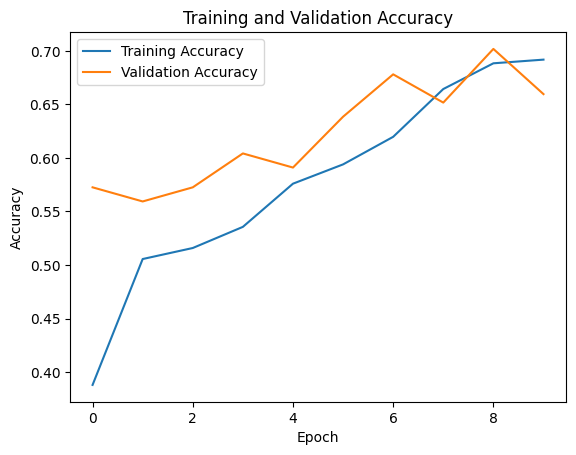

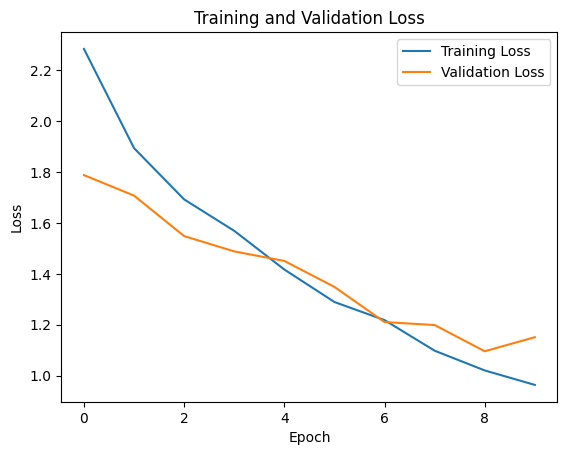

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("/kaggle/working/rgb_lstm_accuracy.png")
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/kaggle/working/rgb_lstm_loss.png")
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 90s 9s/step
y_test_bin shape: (310, 14)
y_prob shape: (310, 14)
Class Abuse - AUC: 0.62
Class Arrest - AUC: 0.88
Class Arson - AUC: 0.96
Class Assault - AUC: 0.90
Class Burglary - AUC: 0.93
Class Explosion - AUC: 0.82
Class Fighting - AUC: 0.93
Class Normal_Videos - AUC: 0.97
Class RoadAccidents - AUC: 0.96
Class Robbery - AUC: 0.91
Class Shooting - AUC: 0.68
Class Shoplifting - AUC: 0.87
Class Stealing - AUC: 0.82
Class Vandalism - AUC: 0.86


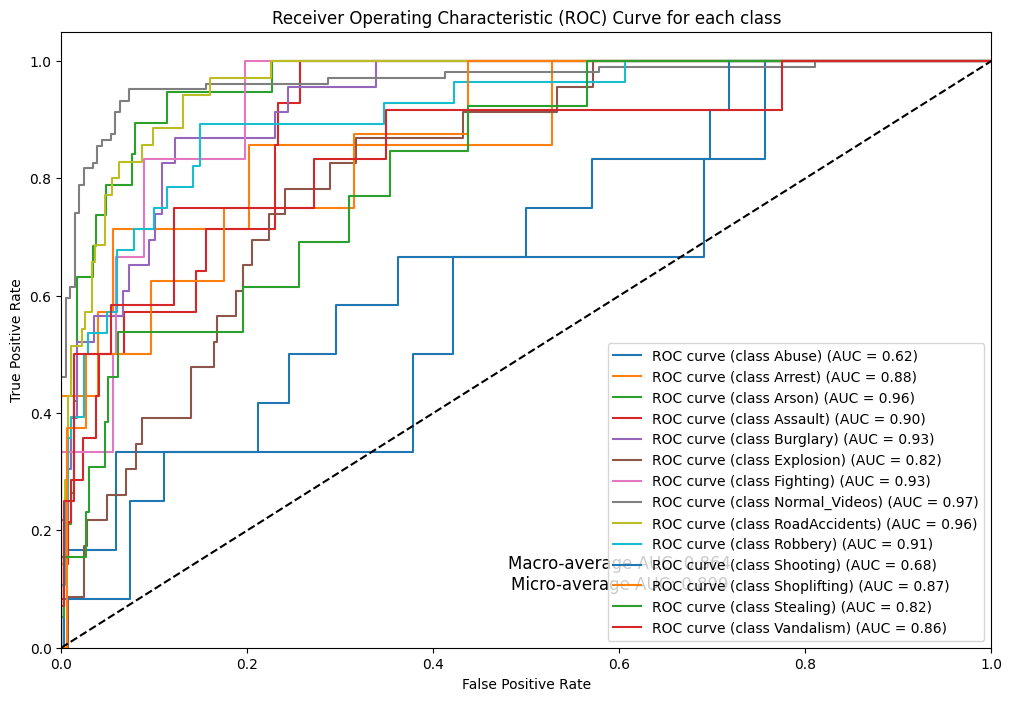

In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

NB_CLASSES = 14

y_prob = model.predict([test_data_padded, test_i3d_features])

print("y_test_bin shape:", test_classes.shape)
print("y_prob shape:", y_prob.shape)        


fpr = dict()
tpr = dict()
roc_auc = dict()

class_labels = label_encoder.classes_


for i in range(NB_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(test_classes[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f'Class {class_labels[i]} - AUC: {roc_auc[i]:.2f}') 
plt.figure(figsize=(12, 8))
for i in range(NB_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {class_labels[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')


macro_auc = np.mean(list(roc_auc.values()))
y_prob_flat = y_prob.ravel()
test_classes_flat = test_classes.ravel()
micro_auc = roc_auc_score(test_classes_flat, y_prob_flat, average='micro')


plt.text(0.6, 0.1, f'Macro-average AUC: {macro_auc:.3f}\nMicro-average AUC: {micro_auc:.3f}', fontsize=12, ha='center')
plt.legend(loc="lower right")


plt.savefig("/kaggle/working/rgb_lstm_ROC.png")
plt.show()

In [39]:
os.listdir('/kaggle/working')

['rgb_lstm_ROC.png',
 'rgb_lstm_accuracy.png',
 '.virtual_documents',
 'rgb_lstm_loss.png']

In [40]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/rgb_lstm_ROC.png')

/kaggle/working/rgb_lstm_ROC.png

In [41]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/rgb_lstm_accuracy.png')


/kaggle/working/rgb_lstm_accuracy.png

In [42]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/rgb_lstm_loss.png')

/kaggle/working/rgb_lstm_loss.png